
Found 1161 valid (even-only) pairs.
🔁 Training on EVEN-only data...
Epoch 1/200
232/232 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.4948 - iou: 0.2558 - loss: 0.5909 - precision: 0.4937 - recall: 0.9690 - val_accuracy: 0.4924 - val_iou: 0.2462 - val_loss: 0.5878 - val_precision: 0.4924 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/200
232/232 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4983 - iou: 0.2491 - loss: 0.5847 - precision: 0.4983 - recall: 1.0000 - val_accuracy: 0.4924 - val_iou: 0.2462 - val_loss: 0.5874 - val_precision: 0.4924 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 3/200
232/232 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.4950 - iou: 0.2475 - loss: 0.5848 - precision: 0.4950 - recall: 1.0000 - val_accuracy: 0.4924 - val_iou: 0.2462 - val_loss: 0.5853 - val_precision: 0.4924 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 4/200
232/232 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.4993 - iou: 0.2497 - loss: 0.5821 - precision: 

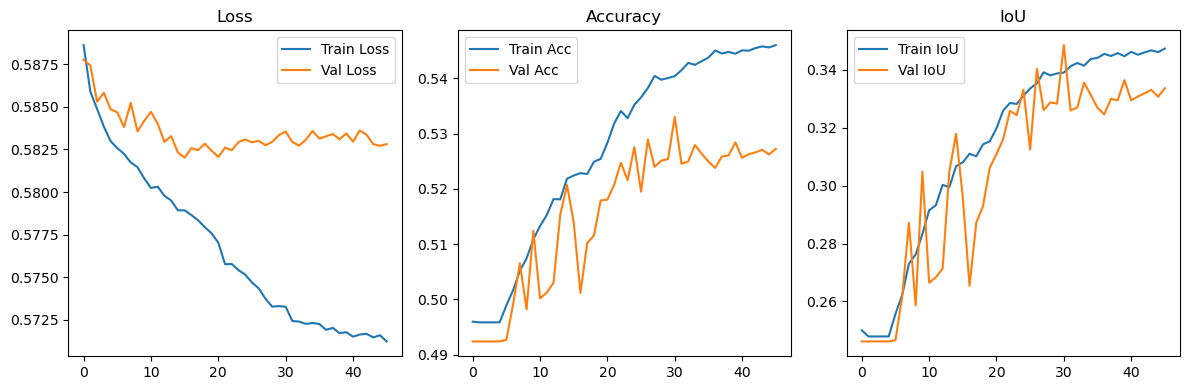

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.utils import Sequence
import warnings

warnings.filterwarnings('ignore')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# === Configuration ===
base_dir = "F:/Education/NSU/CSE/CSE499/Implementation/Image Data"
input_even_dir = os.path.join(base_dir, "gray_image", "even_images")
output_dir = os.path.join(base_dir, "matrix")
input_shape = (32, 32, 1)
output_shape = (50, 50, 1)
batch_size = 4
epochs = 200

# === Custom Loss Function ===
def improved_loss(y_true, y_pred):
    if y_pred.shape[1] != y_true.shape[1] or y_pred.shape[2] != y_true.shape[2]:
        y_pred = tf.image.resize_with_crop_or_pad(y_pred, y_true.shape[1], y_true.shape[2])

    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = (2. * intersection + 1e-6) / (union + 1e-6)
    dice_loss = 1 - dice

    return 0.5 * bce + 0.5 * dice_loss

# === Model: Even Only ===
def build_even_only_model(input_shape, output_shape):
    input_even = layers.Input(shape=input_shape, name="even_input")

    x = layers.Conv2D(32, 3, activation='relu', padding='same')(input_even)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling2D()(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling2D()(x)
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
    x = layers.Conv2D(1, 1, activation='sigmoid')(x)
    x = layers.Resizing(output_shape[0], output_shape[1])(x)

    return models.Model(inputs=input_even, outputs=x)

# === Data Generator for Even Only ===
class EvenDataGenerator(Sequence):
    def __init__(self, even_dir, out_dir, batch_size, input_shape, output_shape, pairs):
        self.even_dir = even_dir
        self.out_dir = out_dir
        self.batch_size = batch_size
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.pairs = pairs

    def __len__(self):
        return int(np.ceil(len(self.pairs) / self.batch_size))

    def __getitem__(self, idx):
        batch = self.pairs[idx * self.batch_size:(idx + 1) * self.batch_size]
        even_batch = np.zeros((len(batch), *self.input_shape), dtype=np.float32)
        out_batch = np.zeros((len(batch), *self.output_shape), dtype=np.float32)

        for i, (even_path, out_path) in enumerate(batch):
            try:
                even = np.array(Image.open(even_path).convert('L').resize(self.input_shape[:2])) / 255.0
                matrix = np.array(Image.open(out_path).convert('L').resize(self.output_shape[:2])) > 30
                even_batch[i] = np.expand_dims(even, -1)
                out_batch[i] = np.expand_dims(matrix.astype(np.float32), -1)
            except Exception as e:
                print(f"Error loading {even_path}: {e}")

        return even_batch, out_batch

    def on_epoch_end(self):
        np.random.shuffle(self.pairs)

# === Get Valid Pairs (Even Only) ===
def get_even_output_pairs():
    pairs = []
    for f in os.listdir(output_dir):
        if not f.endswith('.png'):
            continue
        base = f[:-4]
        even_path = os.path.join(input_even_dir, f"{base}_even.png")
        out_path = os.path.join(output_dir, f)
        if os.path.exists(even_path):
            pairs.append((even_path, out_path))
    return pairs

# === Main ===
if __name__ == "__main__":
    pairs = get_even_output_pairs()
    print(f"Found {len(pairs)} valid (even-only) pairs.")

    np.random.shuffle(pairs)
    split = int(0.8 * len(pairs))
    train_pairs, val_pairs = pairs[:split], pairs[split:]

    train_gen = EvenDataGenerator(input_even_dir, output_dir, batch_size, input_shape, output_shape, train_pairs)
    val_gen = EvenDataGenerator(input_even_dir, output_dir, batch_size, input_shape, output_shape, val_pairs)

    model = build_even_only_model(input_shape, output_shape)
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-4),
        loss=improved_loss,
        metrics=[
            'accuracy',
            tf.keras.metrics.BinaryIoU(name='iou'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
    )

    callbacks = [
        tf.keras.callbacks.ModelCheckpoint('even_only_model.keras', save_best_only=True, monitor='val_iou', mode='max'),
        tf.keras.callbacks.EarlyStopping(monitor='val_iou', patience=15, mode='max', restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
    ]

    print("🔁 Training on EVEN-only data...")
    history = model.fit(train_gen, validation_data=val_gen, epochs=epochs, callbacks=callbacks, verbose=1)

    print("🔍 Evaluating model...")
    results = model.evaluate(val_gen)
    print(f"Validation Loss: {results[0]:.4f}, Accuracy: {results[1]:.4f}, IoU: {results[2]:.4f}")

    # === Plot training history ===
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title("Loss")

    plt.subplot(1, 3, 2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.legend()
    plt.title("Accuracy")

    plt.subplot(1, 3, 3)
    plt.plot(history.history['iou'], label='Train IoU')
    plt.plot(history.history['val_iou'], label='Val IoU')
    plt.legend()
    plt.title("IoU")
    plt.tight_layout()
    plt.show()
